In [3]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [41]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(2+xdata)/(2-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.1+x)/(2.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(2.1+x)+1./(2.1-x))

def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))


def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))

def kde_epanechnikov_loguniform_mwdm(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(0. - 0.1))/(np.log10(50.)+0.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.-0.1))/(np.log10(50.)+0.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.-0.1)) + 1./(np.log10(50.)+0.1-x))


import seaborn as sns
def plot_pdf(rate_array,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-0.95,1.,101)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            #sindx= numpy.argsort(-kdey_full) # minus reverses sort
            #cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            #m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)
        #legend(loc='lower left')
        return None
    
    elif dat_type == 'slope':
        xxs= numpy.linspace(-2.45,-1.55,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            #uplim68= numpy.amin(m68[m68 > bf])
            #lowlim68= numpy.amax(m68[m68 < bf])
            uplim68 = np.percentile(rate_full,q=84,interpolation='midpoint')
            lowlim68 = np.percentile(rate_full,q=16,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        #legend(loc='upper right')
        #return None
    
    elif dat_type=='mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)
            
    elif dat_type=='loguniform_mwdm':
        xxs= numpy.linspace(0.,np.log10(50.)-0.1,101)
        kdey_full= kde_epanechnikov_loguniform_mwdm(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        
        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            #cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            uplim_95 = np.percentile(rate_full,q=95,interpolation='midpoint')
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (10**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            lowlim_95 = np.percentile(rate_full,q=5,interpolation='midpoint')
            #ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            #lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.1f \ \mathrm{keV} \ (95\,\%%)$' % (10**lowlim_95),
                               size=16.,top_left=True)

        #legend(loc='upper right')
        
        
    return None



### Combine rate by simply multiplying the PDFs

In [5]:
#Pal5

abc_diff=np.loadtxt('dens_Omega/Pal5_ABC_rate_power_diff_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_hi=0.3
tol_med=0.2
tol_lo=0.1

accepted_rate_P5=[]
NN=len(abc_diff)


for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff[ii][0]
    
    diff_hi=abc_diff[ii][1]
    diff_med=abc_diff[ii][2]
    diff_lo=abc_diff[ii][3]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_hi < tol_hi) and (diff_med < tol_med) and (diff_lo < tol_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_rate_P5.append(np.log10(rate))
                        
print (len(abc_diff), len(accepted_rate_P5))

996769 20132


In [8]:
#GD1

dir2 = 'dens_Omega/sims_for_ABC_loguniform_rate_margTage/'


abc_diff_tr=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.4
tol_tr_med=0.3
tol_tr_lo=0.2
    

tol_le_hi=0.4
tol_le_med=0.3
tol_le_lo=0.2
   

accepted_rate_GD1=[]
rate_all=[]
accepted_Tage=[]
Tage_all=[]

NN=len(abc_diff_tr)
count = NN

for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff_tr[ii][0]
    rate_all.append(np.log10(rate))
    Tage=abc_diff_tr[ii][1]
    Tage_all.append(Tage)
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][2]
    diff_tr_med=abc_diff_tr[ii][3]
    diff_tr_lo=abc_diff_tr[ii][4]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][2]
    diff_le_med=abc_diff_le[ii][3]
    diff_le_lo=abc_diff_le[ii][4]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_rate_GD1.append(np.log10(rate))
        accepted_Tage.append(Tage)
        
        
print (count, len(accepted_rate_GD1))

1010000 20692


1.1056147098942077


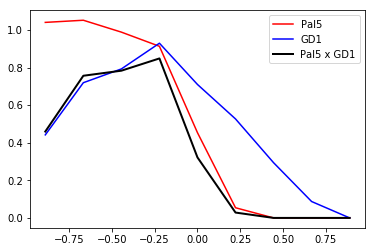

In [20]:
rate_bins=np.linspace(-1.,1.,10)

mid_bin=[0.5*(rate_bins[i]+rate_bins[i+1]) for i in range(len(rate_bins)-1)]

pdf_P5,_=np.histogram(accepted_rate_P5,bins=rate_bins,density=True)
pdf_GD1,_=np.histogram(accepted_rate_GD1,bins=rate_bins,density=True)

print (10**(np.percentile(pdf_GD1,q=5,interpolation='midpoint')))

plt.figure()
plt.plot(mid_bin,pdf_P5,c='r',label='Pal5')
plt.plot(mid_bin,pdf_GD1,c='b',label='GD1')
plt.plot(mid_bin,pdf_P5*pdf_GD1,c='k',lw=2,label='Pal5 x GD1')
plt.legend(loc='upper right')

plt.show()



### combine based on combined tolerances amp,slope,mwdm case

In [29]:
dir_P5 = 'dens_Omega/Pal5_ABC_amp_slope_mwdm_diff/'

P5_amp=[]
P5_slope=[]
P5_mwdm=[]
P5_diff_hi= []
P5_diff_med=[]
P5_diff_lo=[]

for ii in range(50):
    P5_abc_diff=np.loadtxt(dir_P5 + 'Pal5_ABC_loguniformamp_uniformslope_loguniformmwdm_lenthreshold0.2_barspiral_NRaoBlackwell100_{}.dat'.format(ii),delimiter=',',skiprows=1)

    NN=len(P5_abc_diff)
    for ii in range(NN):
        #print (abc_diff[ii])
        P5_slope.append(P5_abc_diff[ii][0])
        P5_amp.append(P5_abc_diff[ii][1])
        P5_mwdm.append(P5_abc_diff[ii][2])
        
        P5_diff_hi.append(P5_abc_diff[ii][4])
        P5_diff_med.append(P5_abc_diff[ii][5])
        P5_diff_lo.append(P5_abc_diff[ii][6])

#GD1
GD1_amp=[]
GD1_slope=[]
GD1_mwdm=[]

GD1_diff_tr_hi= []
GD1_diff_tr_med=[]
GD1_diff_tr_lo=[]

GD1_diff_le_hi= []
GD1_diff_le_med=[]
GD1_diff_le_lo=[]


dir2 = 'dens_Omega/sims_for_ABC_loguniformamp_uniformslope_loguniformmwdm_margTage/'

for jj in range(50):
    
    abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_amp_uniform_slope_loguniform_mwdm_power_diff_trailing_lenthreshold0.2_barspiral_NRaoBlackwell100_0{}.dat'.format(jj),delimiter=',',skiprows=1)
    abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_amp_uniform_slope_loguniform_mwdm_power_diff_leading_lenthreshold0.2_barspiral_NRaoBlackwell100_0{}.dat'.format(jj),delimiter=',',skiprows=1)

    NN=len(abc_diff_tr)

    for ii in range(NN):
        #print (abc_diff[ii])
        GD1_amp.append(abc_diff_tr[ii][0])
        GD1_slope.append(abc_diff_tr[ii][1])
        GD1_mwdm.append(abc_diff_tr[ii][2])
        #Tage=abc_diff_tr[ii][3]

        #Trailing
        GD1_diff_tr_hi.append(abc_diff_tr[ii][4])
        GD1_diff_tr_med.append(abc_diff_tr[ii][5])
        GD1_diff_tr_lo.append(abc_diff_tr[ii][6])

        #Leading
        GD1_diff_le_hi.append(abc_diff_le[ii][4])
        GD1_diff_le_med.append(abc_diff_le[ii][5])
        GD1_diff_le_lo.append(abc_diff_le[ii][6])

In [39]:
accepted_slope=[]
accepted_amp=[]
accepted_mwdm=[]

P5_tol_hi=0.5
P5_tol_med=0.4
P5_tol_lo=0.3

GD1_tol_tr_hi=0.4
GD1_tol_tr_med=0.3
GD1_tol_tr_lo=0.2

GD1_tol_le_hi=0.4
GD1_tol_le_med=0.3
GD1_tol_le_lo=0.2

for ii in range(1001000):
    
    if (GD1_diff_tr_hi[ii] < GD1_tol_tr_hi) and (GD1_diff_tr_med[ii] < GD1_tol_tr_med) and (GD1_diff_tr_lo[ii] < GD1_tol_tr_lo)\
    and (GD1_diff_le_hi[ii] < GD1_tol_le_hi) and (GD1_diff_le_med[ii] < GD1_tol_le_med) and (GD1_diff_le_lo[ii] < GD1_tol_le_lo)\
    and (P5_diff_hi[ii] < P5_tol_hi) and (P5_diff_med[ii] < P5_tol_med) and (P5_diff_lo[ii] < P5_tol_lo):
    
        accepted_slope.append(GD1_slope[ii])
        accepted_amp.append(np.log10(GD1_amp[ii]))
        accepted_mwdm.append(np.log10(GD1_mwdm[ii]))
        #accepted_Tage.append(Tage)
        
print (len(accepted_amp))        


5406


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


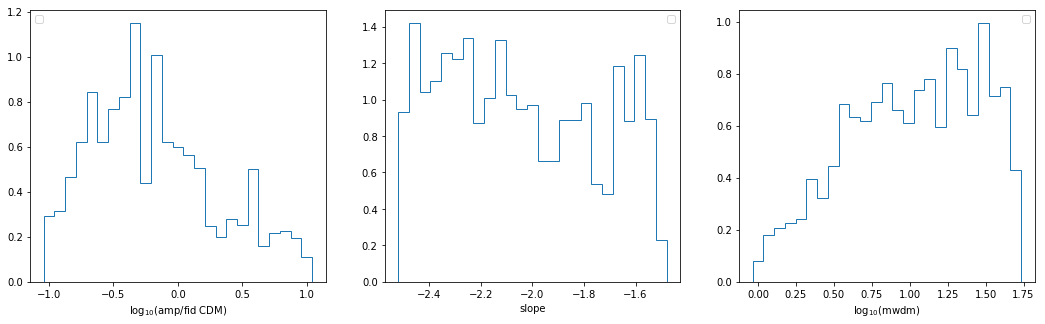

In [40]:
mid_amp=np.linspace(-1.0,1.0,25)
mid_slope=np.linspace(-2.5,-1.5,25)
mid_mwdm=np.linspace(0.,np.log10(50.),25)

Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]

bw_amp=mid_amp[1]-mid_amp[0]
bw_slope=mid_slope[1]-mid_slope[0]
bw_mwdm=mid_mwdm[1]-mid_mwdm[0]

amp_bin_edge=[mid_amp[0]-0.5*bw_amp + bw_amp*i for i in range(len(mid_amp)+1)]
slope_bin_edge=[mid_slope[0]-0.5*bw_slope + bw_slope*i for i in range(len(mid_slope)+1)]
mwdm_bin_edge=[mid_mwdm[0]-0.5*bw_mwdm + bw_mwdm*i for i in range(len(mid_mwdm)+1)]

#count_slope,bin_edge=np.histogram(accepted_slope,slope_bin_edge,density=True)
#count_amp,bin_edge=np.histogram(accepted_amp,amp_bin_edge,density=True)
#count_mwdm,bin_edge=np.histogram(accepted_1_over_mwdm,mwdm_bin_edge,density=True)
#count_Tage=np.histogram(Tage,Tage_bin,density=True)[0]
#count_Tage_all=np.histogram(Tage_all,Tage_bin,density=True)[0]

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.hist(accepted_amp,bins=amp_bin_edge,histtype='step',density=True)
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')

plt.subplot(1,3,2)
plt.hist(accepted_slope,bins=slope_bin_edge,histtype='step',density=True)
plt.legend(loc='upper right')
plt.xlabel("slope")

plt.subplot(1,3,3)
plt.hist(accepted_mwdm,bins=mwdm_bin_edge,histtype='step',density=True)
plt.legend(loc='upper right')
#plt.ylabel("PDF")
plt.xlabel(r"log$_{10}$(mwdm)")


#plt.savefig("lognormalamp3sigma_slope_mwdm_posterior_PDF.pdf")
plt.show()



(0.0, 1.2)

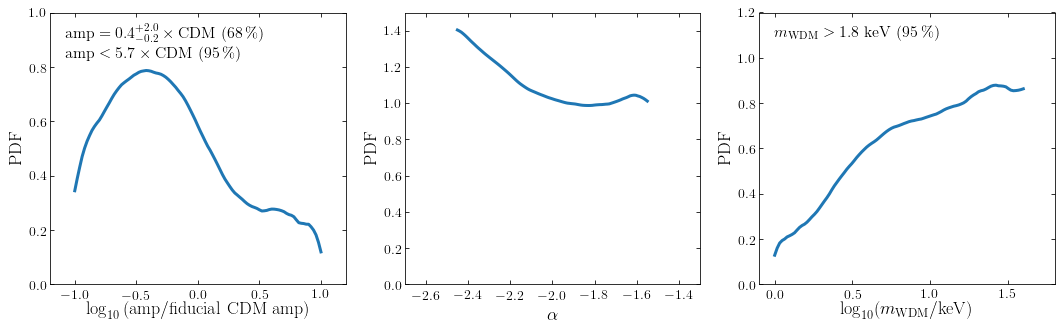

In [43]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)

plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.4,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.5)

subplot(1,3,3)
plot_pdf(np.array(accepted_mwdm),dat_type='loguniform_mwdm',add_95low=True,kernel_width=0.8,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}(m_{\mathrm{WDM}}/ \mathrm{keV})$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.8)
ylim(0.,1.2)
#savefig("paper_plots/GD1_ABC_posterior_amp_slope_mwdm.pdf",bbox_inches='tight')